In [ ]:
%pip install gdown transformers datasets tensorflow scikit-learn tf-keras

## Dataset loading options

From Google Drive

In [ ]:
file_id = "0Bz8a_Dbh9QhbZVhsUnRWRDhETzA"
output_name = 'amazon_review_full_csv.tar.gz'
!gdown --fuzzy https://drive.google.com/uc?id={file_id} -O {output_name}

From local storage

In [ ]:
# from google.colab import files

# uploaded = files.upload()
# # Assume che il CSV sia il primo file caricato
# print(f"Select train dataset .csv from your local storage:. . .")
# train_data_filename = list(uploaded.keys())[0]

In [ ]:
# uploaded = files.upload()
# # Assume che il CSV sia il primo file caricato
# print(f"Select test dataset .csv from your local storage:. . .")
# test_data_filename = list(uploaded.keys())[0]

In [ ]:
import tarfile

with tarfile.open(output_name, "r:gz") as tar:
    tar.extractall("Dataset")

In [ ]:
!ls -R Dataset

## Import Libraries

In [ ]:
import pandas as pd
import json
import tensorflow as tf
import tf_keras as keras 
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel

## Model settings

In [ ]:
MODEL_NAME    = "roberta-base"
BATCH_SIZE    = 32
EPOCHS        = 5
LEARNING_RATE = 2e-5
NUM_LABELS    = 2
RANDOM_STATE = 42

In [ ]:
train_data_filename = "./Dataset/amazon_review_full_csv/train.csv"
test_data_filename = "./Dataset/amazon_review_full_csv/test.csv"

## Train dataset loading

In [60]:
print(f"Loading dataset from: {train_data_filename}")

df_train = pd.read_csv(
    train_data_filename,
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  
    )

Loading dataset from: ../Dataset/amazon_review_full_csv/train.csv


In [61]:
df_train.shape[0]

2999746

In [62]:
df_train.describe()

,label
count,2.999746e+06
mean,3.000022e+00
std,1.414218e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [63]:
df_train.head()

,label,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [64]:
df_train.isna().sum()

label      0
title    188
text       0
dtype: int64

Drop rows with at least a null value

In [65]:
df_train.dropna(inplace=True)
df_train.shape[0]

2999558

In [66]:
df_train.isna().sum()

label    0
title    0
text     0
dtype: int64

In [67]:
df_test = pd.read_csv(
    test_data_filename,
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  
    )

In [68]:
df_test.describe()

,label
count,649954.000000
mean,3.000011
std,1.414217
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [69]:
df_test.shape[0]

649954

In [70]:
df_test.isna().sum()

label     0
title    26
text      0
dtype: int64

In [71]:
df_test.dropna(inplace=True)

In [72]:
df_test.isna().sum()

label    0
title    0
text     0
dtype: int64

In [73]:
df_test.shape[0]

649928

Drop rows with rating '3' from both train and test sets

In [74]:
df_train = df_train[df_train['label'] != 3]
df_test = df_test[df_test['label'] != 3]

In [75]:
df_train.shape[0]

2399666

In [76]:
df_test.shape[0]

519942

## Ratings binary mapping

In [77]:
# Function to convert ratings (1-5) into 3 classes:
def map_rating(row):
    rating = row['label']
    if rating <= 2:
        return 0  # negative
    else:
        return 1  # positive

In [78]:
df_train_mapped = df_train.copy(deep=True)

df_train_mapped['sentiment'] = df_train_mapped.apply(map_rating, axis=1)


 ### Downsample Balanced Train Set

In [79]:
from sklearn.model_selection import train_test_split

### Experiment with a trainset of 1k samples

In [ ]:
SAMPLE_SIZE = 30000

In [ ]:
df_train_mapped, _ = train_test_split(
    df_train_mapped,
    train_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train_mapped['label']
)
print(f"Train size: {len(df_train_mapped)}")

Train size: 100000


Let's check whether classes are balanced

In [81]:
print(df_train_mapped['label'].value_counts())

label
5    25001
4    25001
2    24999
1    24999
Name: count, dtype: int64


In [82]:
df_train_mapped.drop(columns=["label"], inplace=True)
display(df_train_mapped.head())

,title,text,sentiment
2281053,Great Game,I purchased this as a gift for my brother and ...,1
1535186,Grainy and blocky,"The movie was good, its the video compression ...",0
942601,doesn't even deserve 1 star,This is the worst horror movie ever written..V...,0
1523608,semi scholarship,Although based on the premise of a real book o...,0
1081248,It doesn&#65533;t make you cool to dislike thi...,"If you genuinely don't like this movie, I unde...",1


In [83]:
df_train_mapped['review'] = df_train_mapped['title'].fillna('') + ' ' + df_train_mapped['text'].fillna('')

train_samples = df_train_mapped['review']
train_labels = df_train_mapped['sentiment'].values

## NLTK libraries

In [84]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('popular')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorisgiunta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lorisgiunta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!

True

In [85]:
train_samples = train_samples.str.replace('\n', ' ', regex=False) 
train_samples = train_samples.str.lower()

## Setting Tokenizer

This approach uses the same tokenizer used during the model `MODEL_NAME` pretraining. This allow to preserve the context and language semantics.

`AutoTokenizer` is able to infer automatically the model used.

For example we can possible use RobertaTokenizer, but only if we are sure that we'll use RoBERTa model.

## Analyze tokens distribution to choose the best trade-off for MAX_LEN.
The idea is to use the 95th percentile to reduce padding and truncate only outliers.

In [ ]:
import numpy as np

# 50000 samples are good enough to get a stable estimation of tokens distribution
sample_texts = train_samples.sample(n=2000, random_state=RANDOM_STATE).tolist()

# Tokenizza solo per analisi (senza padding)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
token_lens = [len(tokenizer.tokenize(t)) for t in sample_texts]


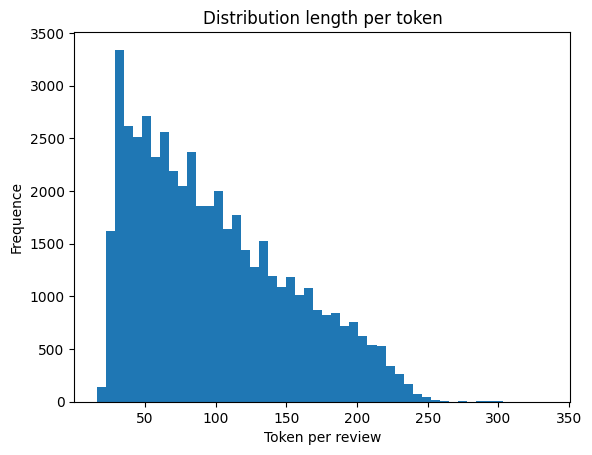

In [87]:
import matplotlib.pyplot as plt

plt.hist(token_lens, bins=50)
plt.title("Distribution length per token")
plt.xlabel("Token per review")
plt.ylabel("Frequence")
plt.show()

In [88]:
print("Token length stats:")
print(f"Mean: {np.mean(token_lens):.1f}")
print(f"95th percentile: {np.percentile(token_lens, 95):.0f}")
print(f"Max: {np.max(token_lens)}")

Token length stats:
Mean: 98.8
95th percentile: 203
Max: 335


The 95th percentile of tokenized length is around ~200, meaning that 95% of the reviews are shorter than this threshold.

To balance memory efficiency and minimize information loss, we set `MAX_LEN = 205`:
- This truncates only the top 5% longest reviews (outliers).
- It reduces unnecessary padding for the remaining 95% of the data.
- It ensures consistent input size for the model without significant loss of content.

In [ ]:
MAX_LEN = 205

In [90]:
train_samples.shape

(100000,)

### Una-tantum tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

texts   = train_samples.tolist()

encodings = tokenizer(
    texts,
    max_length=MAX_LEN,
    truncation=True,
    padding='do_not_pad',
    return_attention_mask=True,
   
)


In [ ]:
from google.colab import drive
import os
# drive.mount("/content/drive")         

# save_dir = "/content/drive/MyDrive/Tokenization_cache"
# os.makedirs(save_dir, exist_ok=True)

# # save on disk
# np.savez_compressed(
#     os.path.join(save_dir,"train_enc_roberta_30k.npz"),
#     ids   = np.array(encodings["input_ids"], dtype=object),
#     attn  = np.array(encodings["attention_mask"], dtype=object),
#     label = train_labels
# )

# save on temporary session
np.savez_compressed(
   "train_enc_roberta_30k.npz",
    ids   = np.array(encodings["input_ids"], dtype=object),
    attn  = np.array(encodings["attention_mask"], dtype=object),
    label = train_labels
)

# print("Tokenization completed and saved in", save_dir)

ModuleNotFoundError: No module named 'google.colab'

### Load saved indexes

In [ ]:
d = np.load("train_enc_roberta_30k.npz", allow_pickle=True)

In [ ]:
def generator():
    for ids, attentions, labels in zip(d["ids"], d["attn"], d["label"]):
        yield {
            "input_ids":     np.array(ids,  dtype=np.int32),
            "attention_mask": np.array(attentions, dtype=np.int32)
        }, np.int32(labels)

In [ ]:
raw_ds = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        {
            "input_ids":      tf.TensorSpec(shape=(None,), dtype=tf.int32),
            "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32),
        },
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ),
)

### Custom encoder to enable dynamic padding. It inserts padding till the max length of the current batch.

This code is used only for on the fly encoding

In [ ]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# # funzione Python pura: restituisce SOLO tensori, senza dict
# def _py_encode(text, label):
#     enc = tokenizer(
#         text.numpy().decode(),
#         truncation=True,
#         max_length=MAX_LEN,
#         return_attention_mask=True,
#     )
#     return (                # tuple flat di tre tensor
#         tf.constant(enc["input_ids"],      dtype=tf.int32),
#         tf.constant(enc["attention_mask"], dtype=tf.int32),
#         tf.cast(label, tf.int32),
#     )

# # wrapper tf → rimappa la tupla in un dict per Keras
# def tf_encode(text, label):
#     input_ids, attn_mask, lab = tf.py_function(
#         _py_encode,
#         inp=[text, label],
#         Tout=(tf.int32, tf.int32, tf.int32)   # usato per dichiarare a TensorFlow il tipo di ciascun tensore che la funzione Python restituirà.
#     )
#     # Imposta le shape dinamiche, altrimenti sono <unknown>
#     input_ids.set_shape([None])
#     attn_mask.set_shape([None])
#     lab.set_shape([])

#     return {'input_ids': input_ids,
#             'attention_mask': attn_mask}, lab



In [ ]:
# tensor_dataset = (
#     raw_ds
#     .map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
#     .padded_batch(
#         BATCH_SIZE,
#         padded_shapes=({'input_ids':[None], 'attention_mask':[None]}, []),
#         padding_values=({'input_ids': tokenizer.pad_token_id,
#                          'attention_mask': 0}, 0),
#     )
#     .prefetch(tf.data.AUTOTUNE)                       
# )

In [ ]:
tensor_dataset = (
    raw_ds
    .shuffle(len(d["label"]), seed=RANDOM_STATE)
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=({'input_ids':[None], 'attention_mask':[None]}, []),
        padding_values=({'input_ids': tokenizer.pad_token_id,
                         'attention_mask': 0}, 0),
    )
    .prefetch(tf.data.AUTOTUNE)
)

## Choose whether retrain encoder or not

In [ ]:
ENCODER_TRAINABLE = True

In [ ]:
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from transformers import TFRobertaModel
encoder = TFRobertaModel.from_pretrained(MODEL_NAME)
encoder.trainable = True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
input_ids      = keras.Input(shape=(None,), dtype="int32", name="input_ids")
attention_mask = keras.Input(shape=(None,), dtype="int32", name="attention_mask")

Link to pretrained encoders info: https://huggingface.co/transformers/v2.4.0/pretrained_models.html

In [ ]:
# executed for each batch
# here roberta converts input_ids into embedding vectors (batch_size, seq_len, hidden_size) where hidden_size = 768 for roberta-base.
encoder_outputs = encoder({'input_ids': input_ids, 'attention_mask': attention_mask}, training = True)
pooled_output = encoder_outputs.pooler_output

# last hidden state is a tensor (batch_size, seq_len, hidden_size) containing the contextual representation of each token.
# cls is used to represent the entire sentence
# hidden_states = encoder_outputs.last_hidden_state
# cls_token = hidden_states[:, 0, :]

### Building Classification Head

In [ ]:

x = keras.layers.Dense(256, activation='relu', name='dense_relu')(pooled_output)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.LayerNormalization()(x)

logits = keras.layers.Dense(NUM_LABELS, name='logits')(x)


### Entire model

In [ ]:
model = keras.Model(inputs=[input_ids, attention_mask], outputs=logits)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 210)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 210)]                0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['attention_mask[0][0]',      
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_ids[0][0]']           
                             hidden_state=(None, 210, 7                                     

Check that encoder parameters are not retrainable

In [105]:
for i, layer in enumerate(model.layers):
    print(f"{layer.name:25s}  trainable={layer.trainable}")

attention_mask             trainable=True
input_ids                  trainable=True
tf_roberta_model_1         trainable=False
tf.__operators__.getitem_1  trainable=True
dense_relu                 trainable=True
logits                     trainable=True


In [ ]:
base_opt = keras.optimizers.AdamW(           # da tensorflow-addons
    learning_rate = LEARNING_RATE,
    weight_decay  = 1e-2,
    epsilon       = 1e-8,
    clipnorm      = 1.0,

)

optimizer = keras.mixed_precision.LossScaleOptimizer(base_opt)
loss=  keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"])

In [ ]:
total_batches = tf.data.experimental.cardinality(tensor_dataset).numpy() 
val_batches   = int(total_batches * 0.2)               

val_dataset   = tensor_dataset.take(val_batches)      
train_dataset = tensor_dataset.skip(val_batches)

Define batches

In [ ]:
N = len(d["label"])
steps_per_epoch = N // BATCH_SIZE
val_size      = int(0.2 * N)
val_batches   = val_size // BATCH_SIZE
train_batches = (N - val_size) // BATCH_SIZE

Split dataset

In [ ]:
val_dataset   = tensor_dataset.take(val_batches)
train_dataset = tensor_dataset.skip(val_batches)

In [ ]:
import time
start_time = time.time()

In [ ]:
from tf_keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',        # controlla la loss di validazione
    patience=2,                # se non migliora per 2 epoche, interrompe
    restore_best_weights=True, # ricarica i pesi migliori visti finora
    verbose=1                  # stampa un messaggio quando scatta
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data= val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop] 
)

Epoch 1/5
  11/5000 [..............................] - ETA: 1:57:49 - loss: 6.4087 - accuracy: 0.4943

KeyboardInterrupt: 

In [ ]:
end_time = time.time()
elapsed = end_time - start_time

print(f"⏱️ Total training time: {elapsed:.1f} s ({elapsed/60:.2f} min)")

### Save model

In [ ]:
import time, json, os
from google.colab import drive

drive.mount('/content/drive')

save_path = '/content/drive/HLT_models/roberta-keras-custom'
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

metadata = {
    "timestamp":          time.strftime("%Y-%m-%d %H:%M:%S"),
    "total_training_time_s": round(elapsed, 1),
    "num_train_samples":     SAMPLE_SIZE,
    "batch_size":            BATCH_SIZE,
    "epochs":                EPOCHS,
    "encoder_trainable":     ENCODER_TRAINABLE,
    "history":               history.history   # contiene loss & metriche per epoca
}

with open(os.path.join(save_path, 'training_metadata_roberta_custom.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Saved model + tokenizer + metadata in {save_path}")